# REINFORCE

**Policy-based methods** learn directly a parameterized policy that can select actions without consulting a value function.

First of all we implement a parametric policy as a neural network that takes the state as input and outputs a probability distribution over the actions:

In [2]:
import torch

class PolicyApproximator(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(PolicyApproximator, self).__init__()

        # define the activation function (ReLU)
        self.activation = torch.nn.functional.relu

        # defining the input layer
        self.input_layer = torch.nn.Linear(state_size, 512)

        # creating the hidden layers 
        self.hidden_layers = torch.nn.ModuleList()
        self.hidden_layers.append(torch.nn.Linear(512, 128))
        
        # connecting the output layer    
        self.output_layer = torch.nn.Linear(128, action_size)
        
    def forward(self, state):
        # take in the raw state and convert it into a tensor
        # also unsqueezing it in order to change it's shape
        if not isinstance(state, torch.Tensor):
            state = torch.Tensor(state)

        # pass it through the input layer
        x = self.activation(self.input_layer(state))

        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))

        # finally, pass for the output layer
        preferences = self.output_layer(x)

        return preferences
    
    def select_action(self, state):

        # get the preferences over actions
        preferences = self.forward(state)

        # sample the action from the probability distribution
        dist = torch.distributions.Categorical(logits=preferences)
        action = dist.sample()

        # calculate the log probability of the action, it is needed for the loss
        logpa = dist.log_prob(action).unsqueeze(-1)

        return action.item(), logpa
    
    def select_greedy_action(self, state):
        
        # we select the action with the highest preference
        preferences = self.forward(state)
        action = np.argmax(preferences.detach().numpy())
        
        return action
    

We write the optimization method in order to calculate the loss and make a step of gradient descent. The loss is calculated as the log probability of the actions selected weighted by the returns obtained after that action was selected. 

In [3]:
def optimize(model, rewards, logpas, optimizer, gamma):
        
    T = len(rewards)
    
    # calculate the discounts (as with all Monte Carlo methods)
    discounts = np.logspace(0, T, num=T, base=gamma, endpoint=False)
    
    # calculate the sum of discounted returns for all time steps
    # notice this is the returns for every time step in the episode,
    # from the initial state at time step 0, to one before the terminal T-1.
    returns = np.array([np.sum(discounts[:T-t] * rewards[t:]) for t in range(T)])

    # remove the extra elements and format the variables as expected
    returns = torch.FloatTensor(returns)
    
    # prepare the log probabilities of the actions taken
    logpas = torch.cat(logpas)

    # calculate the policy loss
    loss = -(returns * logpas).mean()
    
    # optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

This time we don't need to create method to implement a epsilon-greedy or greedy strategy, because we can use directly the output of the neural network as a probability distribution over the actions. In the evaluate method instead of selecting only in a greedy way, we can also sample from the learned stochastic policy. The correct thing to do here depends on the environment, but sampling is the safe bet.

In [4]:
def evaluate(approximator, env, episodes=1):
    rewards = []
    for _ in range(episodes):
        state = env.reset()[0]
        rewards.append(0)
        while(True):
            action = approximator.select_greedy_action(state)
            state, reward, is_terminal, is_truncated, info = env.step(action)
            rewards[-1] += reward
            is_done = is_terminal or is_truncated
            if is_done: 
                break
    return np.mean(rewards)

Finally, we can write the complete algorithm, where we collect a full trajectory and then perform an optimization step:

In [11]:
import time
import numpy as np
import random
from itertools import count

import gymnasium

def reinforce(env_name, seed, gamma, max_time, max_episodes, max_score, episodes_window):
    
    # create the environment
    env = gymnasium.make(env_name)

    # access the state and action sizes of the environment 
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # set the seeds for reproducibility of results
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.np_random = np.random.Generator(np.random.PCG64(seed))

    # create the policy model
    policy_model = PolicyApproximator(state_size, action_size)
    
    # create the optimizer
    optimizer = torch.optim.RMSprop(policy_model.parameters(), lr=0.0001)

    # episode stats trackers 
    episode_steps = []
    episode_return = []
    episode_seconds = []
    episode_scores = []  

    # total stats trackers
    total_step = 0
    training_time = 0
    results = np.empty((max_episodes+1, 4))
    results[:] = np.nan
    
    # train until we reach a terminal condition
    for episode in count():

        # get the start time of the episode
        episode_start = time.time()

        # set return to 0
        discounted_return = 0
        
        # reset the environment before starting the episode
        state = env.reset()[0]
        
        # interact with the environment until the episode is done
        logpas = []
        rewards = []

        for step in count():
            
            # select the action using the policy
            action, logpa = policy_model.select_action(state)

            # collect an experience tuple as usual 
            next_state, reward, is_terminal, is_truncated, info = env.step(action)
            is_done = is_terminal or is_truncated
            is_failure = is_terminal and not is_truncated

            # save the log probability and the reward
            logpas.append(logpa)
            rewards.append(reward)

            # update current state to next state
            state = next_state
        
            # update the return
            discounted_return += reward
            
            if is_done: 
                break
        
        # then, run one optimization step
        optimize(policy_model, rewards, logpas, optimizer, gamma)

        # evaluate the learned policy after the episode
        score = evaluate(policy_model, env)

        # timing stuff
        episode_elapsed = time.time() - episode_start

        # update episode stats
        episode_steps.append(step)
        episode_return.append(discounted_return)
        episode_seconds.append(episode_elapsed)
        episode_scores.append(score)

        # update total stats
        total_step += step
        training_time += episode_elapsed  

        # average stats over some recent episodes
        mean_return = np.mean(episode_return[-episodes_window:])
        mean_score = np.mean(episode_scores[-episodes_window:])

        # report results
        results[episode] = total_step, mean_return, mean_score, training_time

        # informative print logging  
        message = 'episode {:04}, steps {:06}, average score {:05.1f}'
        message = message.format(episode, total_step, mean_score)
        print(message, end='\r', flush=True)

        # check max episodes achievement criteria
        if (episode >= max_episodes):
            print(message, ' --> reached_max_episodes ')
            break

        # check max time achievement criteria
        if (training_time >= max_time):
            print(message, ' --> reached_max_time ')
            break

        # check max score achievement criteria
        if (mean_score >= max_score):
            print(message, ' --> reached_max_score ')
            break
    
    return policy_model, score, results

We can run REINFORCE in the cart-pole environment so that we can easily compare it and the DQN value-based method. 

In [12]:
def run_experiment(env_name, algorithm, gamma, seeds, 
                   max_time, max_episodes, max_score, episodes_window):

    # variables to collect results
    results = []
    best_agent = None
    best_eval_score = float('-inf')
    
    for seed in seeds:
        # create the agent
        agent, score, result = algorithm(env_name, seed, gamma, 
                                         max_time, max_episodes, max_score, episodes_window)

        # save the results the best agent
        results.append(result)
        if score > best_eval_score:
            best_eval_score = score
            best_agent = agent
        
    return results, best_agent, best_eval_score

In [13]:
reinforce_results, reinforce_agent, reinforce_score = run_experiment(
env_name = 'CartPole-v1',
algorithm = reinforce, 
seeds = (15, 39, 12, 45, 65),
gamma = 0.99,
max_episodes = 1500,
max_time = 60*3,
max_score = 450,
episodes_window = 50)

episode 0965, steps 081258, average score 453.5  --> reached_max_score 
episode 1389, steps 176151, average score 452.4  --> reached_max_score 
episode 1500, steps 155446, average score 395.4  --> reached_max_episodes 
episode 1500, steps 080451, average score 234.5  --> reached_max_episodes 
episode 1500, steps 138364, average score 382.5  --> reached_max_episodes 


We can save the result to future comparison:

In [14]:
np.save('./saved/reinforce_results', reinforce_results)

We can load the result of DQN in order to compare the performances of the two algorithms:

In [15]:
dqn_results = np.load('./saved/dqn_results.npy')

We can plot the training reward:

In [16]:
import matplotlib.pyplot as plt

def show_result(what, alg_a_name, alg_a_results, alg_b_name, alg_b_results):

    plt.figure(figsize=(12,6))
    
    # steps, train_reward,  eval_score,  time
    alg_a_max  = np.max(alg_a_results, axis=0).T
    alg_a_min  = np.min(alg_a_results, axis=0).T
    alg_a_mean = np.mean(alg_a_results, axis=0).T
    alg_a_episodes = np.arange(len(alg_a_mean[0]))

    alg_b_max  = np.max(alg_b_results, axis=0).T
    alg_b_min  = np.min(alg_b_results, axis=0).T
    alg_b_mean = np.mean(alg_b_results, axis=0).T
    alg_b_episodes = np.arange(len(alg_b_mean[0]))

    if (what == 'total_steps'):
        index = 0;
        title = 'Total Steps'
        label = 'Steps'
    elif(what == 'avg_training_reward'):
        index = 1;
        title = 'Moving Avg Reward (Training)'
        label = 'Reward'
    elif(what == 'avg_evaluation_reward'):
        index = 2;
        title = 'Moving Avg Reward (Evaluation)'
        label = 'Reward'
    elif(what == 'training_time'):
        index = 3;
        title = 'Trainning time)'
        label = 'Time'
    else:
        raise ValueError('Not sure what you want to plot')

    plt.plot(alg_a_max[index], 'b', linewidth=1, label=alg_a_name)
    plt.plot(alg_a_min[index], 'b', linewidth=1)
    plt.plot(alg_a_mean[index], 'b', linewidth=1)
    plt.fill_between(alg_a_episodes, alg_a_min[index], alg_a_max[index], facecolor='b', alpha=0.3)

    plt.plot(alg_b_max[index], 'g', linewidth=1, label=alg_b_name)
    plt.plot(alg_b_min[index], 'g', linewidth=1)
    plt.plot(alg_b_mean[index], 'g', linewidth=1)
    plt.fill_between(alg_b_episodes, alg_b_min[index], alg_b_max[index], facecolor='g', alpha=0.3)

    plt.title(title)
    plt.ylabel(label)
    plt.xlabel('Episodes')
    plt.legend()

    plt.show()

The REINFORCE algorithm works in simple problems, and it has convergence guarantees. But because it uses the full Monte Carlo returns for calculating the gradient, its variance is a problem. The accumulation of random events along a trajectory (including the initial state) and the randomness associated with the stochastic policy is compounded inside the return, making it a high-variance signal that's challenging to interpret.

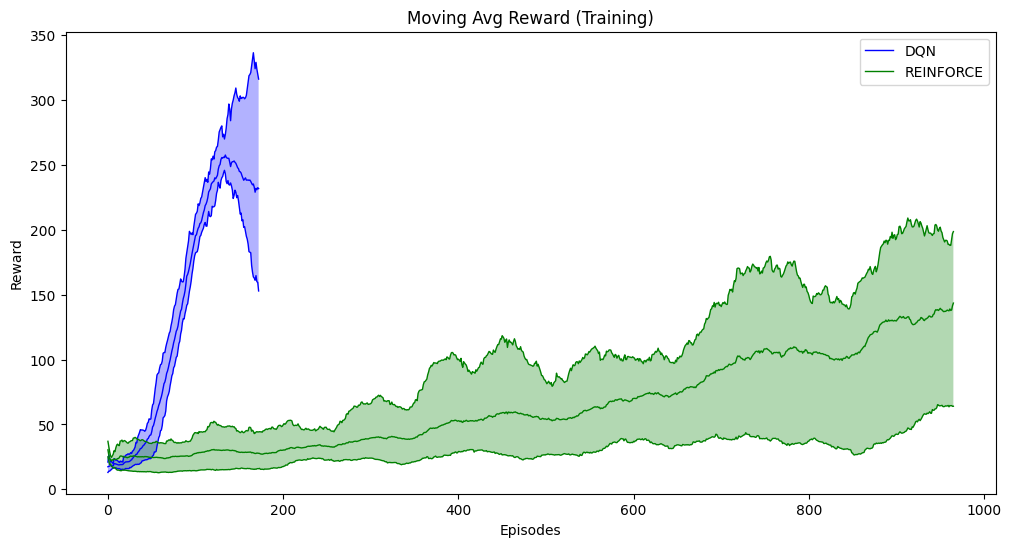

In [17]:
show_result('avg_training_reward','DQN', dqn_results, 'REINFORCE', reinforce_results) 

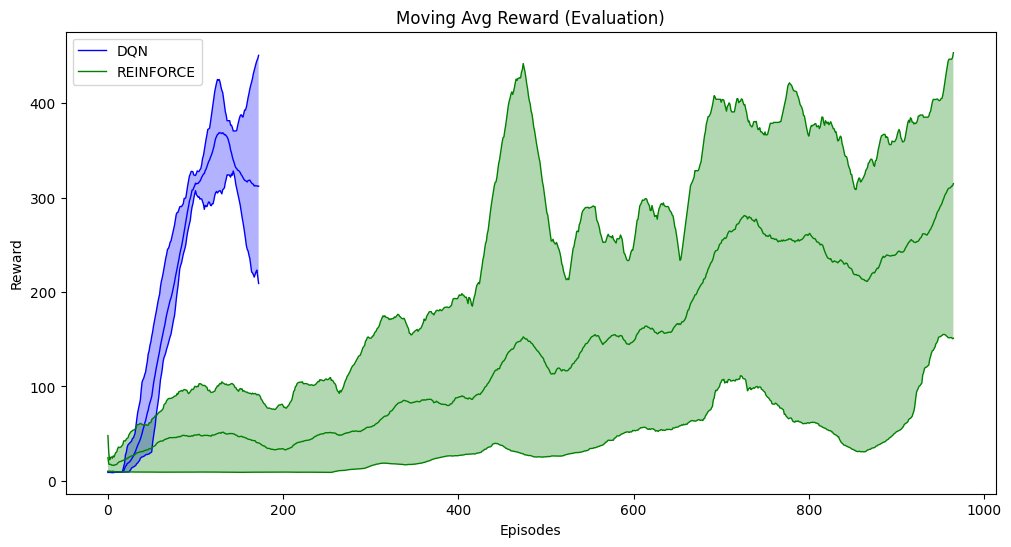

In [18]:
show_result('avg_evaluation_reward','DQN', dqn_results, 'REINFORCE', reinforce_results) 

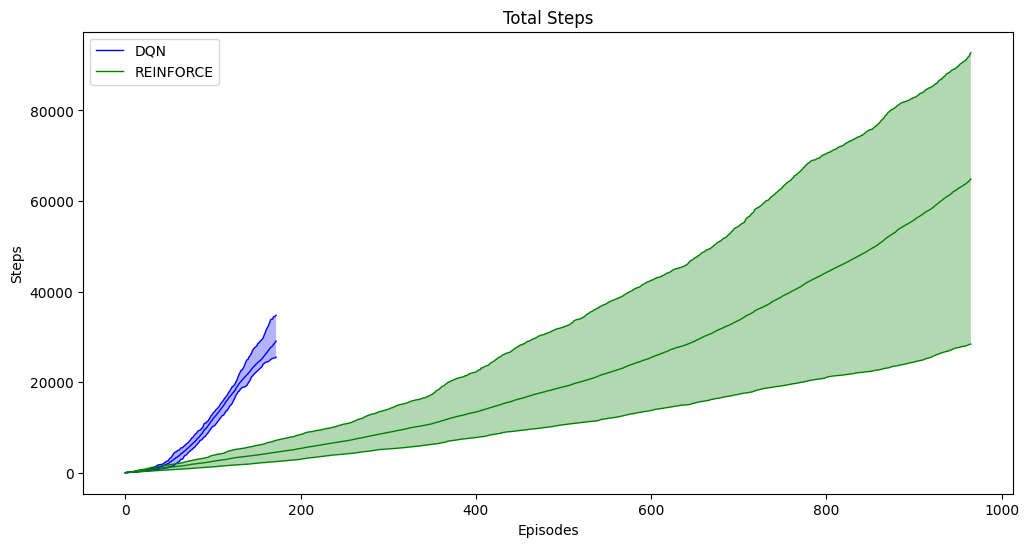

In [19]:
show_result('total_steps','DQN', dqn_results, 'REINFORCE', reinforce_results) 

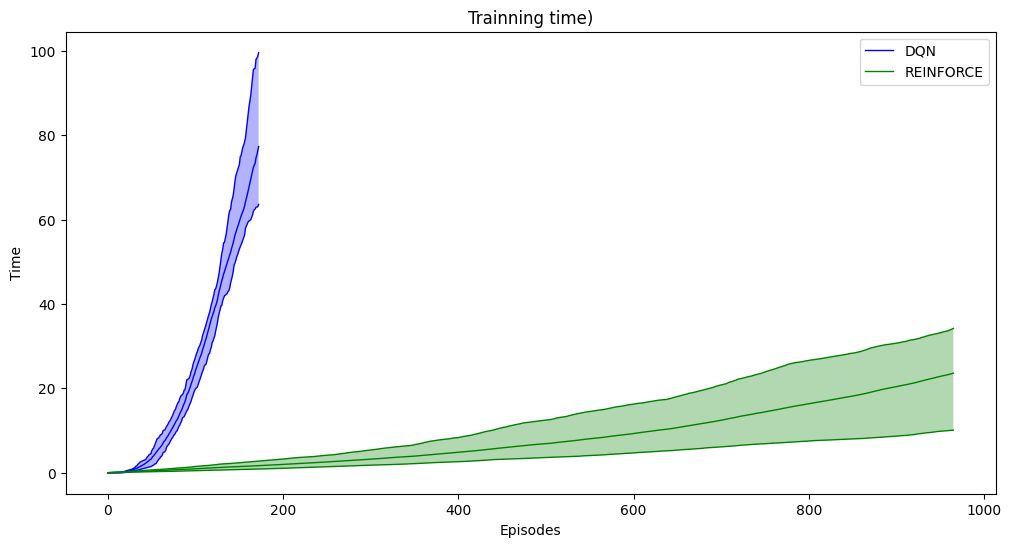

In [20]:
show_result('training_time','DQN', dqn_results, 'REINFORCE', reinforce_results) 

REINFORCE alone is too inefficient to be a practical algorithm. However, in terms of training time, we can see how it uses few resources.